In [12]:
import numpy as np
import xarray as xr
import seaborn as sns
import mplotutils as mpu
import cartopy.crs as ccrs
from netCDF4 import Dataset
from dypy.lagranto import Tra
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.feature as cfeature
from lagranto.plotting import plot_trajs
from matplotlib.colors import ListedColormap
from wrf import to_np, getvar, latlon_coords, CoordPair, ll_to_xy

%matplotlib inline

# Map of Trajectories from Lagranto

In [29]:
def lagranto_plotting(traj_variable_name, start_time, end_time,
                     trajs_bunch_level, subset=False, save=False):
    '''This function plots the chosen variables for the trajectories 
    calculated with Lagranto. Supported variables for plotting procedure 
    are water_vapor and updraft.'''
    
    ### Predefine some variables ###
    traj_data = '/scratch3/thomasl/work/retrospective_part/lagranto/' \
                    'traj_baden_2000_area_0800_east.ll'
    
    start_locations = 'area'
    number_trajs_plot = 2
    
    # Location of Initiation
    lat = 47.25
    lon = 7.85
    initiation = CoordPair(lat, lon)
    
    # Change extent of plot
    subset_extent = [6.2, 9.4, 46.5, 48.5]

    # Variables for getting PBL height of WRF model data
    date = '2018-05-30'
    time = '16:10'
    wrf_filename = '/scratch3/thomasl/work/data/casestudy_baden/wrfout_d02_{}_{}:00'.format(date, time)
    
    # Define save direction
    save_dir = '/scratch3/thomasl/work/retrospective_part'\
                '/casestudy_baden/lagranto/'
    
    # Variables:
    if traj_variable_name == 'water_vapor':
        traj_variable_name = 'QVAPOR'
        title_name = 'Trajectories of Water Vapor'
        colorbar_label_trajs = 'Water Vapor Mixing Ratio [$g$ $kg^{-1}$]'
        save_name = 'trajectory_water_vapor_{}_{}'.format(start_time, end_time)
        traj_variable_min = 0
        traj_variable_max = 15
        
    elif traj_variable_name == 'updraft':
        traj_variable_name = 'W_UP_MAX'
        title_name = 'Trajectories of Updraft'
        colorbar_label_trajs = 'Max Z-Wind Updraft [$m$ $s^-$$^1$]'
        save_name = 'trajectory_updraft_{}_{}'.format(start_time, end_time)
        traj_variable_min = 0
        traj_variable_max = 10
        
    elif traj_variable_name == 'height':
        traj_variable_name = 'z'
        title_name = 'Height of Trajectories'
        colorbar_label_trajs = 'Height of Trajectories [$m$]'
        save_name = 'trajectory_height_{}_{}'.format(start_time, end_time)
        traj_variable_min = 0
        traj_variable_max = 10000
        
    ### Plotting procedure ###
    trajs = Tra()
    trajs.load_ascii(traj_data)
    
    # Get PBL out of WRF model data
    ncfile = Dataset(wrf_filename)
    wrf_file = xr.open_dataset(wrf_filename)
    data = wrf_file.PBLH

    location = ll_to_xy(ncfile, lat, lon)
    data_point = data.sel(west_east=location[0], south_north=location[1])
    pbl = data_point.values
    
    # Separate trajectories in 3 vertical bunches
    # Trajectories of pbl (according to pbl height of WRF model data)
    trajspbl=[]
    for t in trajs:
            if (t['z'][0]<=pbl):
                    trajspbl.append(t)

    # Trajectories between pbl and 5000 m   
    trajs5=[]
    for t in trajs:
            if (t['z'][0]>pbl and t['z'][0]<5000):
                    trajs5.append(t)
    
    # Trajectories between 5000 m and 10000 m                
    trajs10=[]
    for t in trajs:
            if (t['z'][0]>5000 and t['z'][0]<=10000):
                    trajs10.append(t)
    
    if trajs_bunch_level == 'pbl':
        trajs_bunch = trajspbl
        
    elif trajs_bunch_level == '5':
        trajs_bunch = trajs5
        
    elif trajs_bunch_level == '10':
        trajs_bunch = trajs10
    
    elif trajs_bunch_level == 'all':
        trajs_bunch = trajs
    
    # Get terrain height
    terrain_height = getvar(ncfile, 'HGT')/1000 # change to km

    # Define cart projection
    lats, lons = latlon_coords(terrain_height)
    cart_proj = ccrs.LambertConformal(central_longitude=8.722206, 
                                    central_latitude=46.73585)

    # Create figure
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection=cart_proj)

    ### Set map extent ###
    domain_extent = [3.701088, 13.814863, 43.85472,49.49499]

    if subset == True:
        ax.set_extent([subset_extent[0],subset_extent[1],
                       subset_extent[2],subset_extent[3]],
                         ccrs.PlateCarree())

    else: 
        ax.set_extent([domain_extent[0]+0.7,domain_extent[1]-0.7,
                       domain_extent[2]+0.1,domain_extent[3]-0.1],
                         ccrs.PlateCarree())
    
    # Plot trajectories
    levels_trajs = np.linspace(traj_variable_min, traj_variable_max, 11)
    rounded_levels_trajs = [ round(elem, 1) for elem in levels_trajs ]

    cmap = ListedColormap(sns.cubehelix_palette(10, start=.5, rot=-.75,))
    
    plt_trajs = plot_trajs(ax, trajs_bunch[0::number_trajs_plot], traj_variable_name, 
                               linewidth=2, levels=rounded_levels_trajs, 
                               cmap=cmap)

    # Plot the terrain height with colorbar
    levels = np.linspace(0, 4, 21)
    terrain = plt.contourf(to_np(lons), to_np(lats), to_np(terrain_height), 
                 levels=levels, transform=ccrs.PlateCarree(), 
                 cmap=get_cmap('Greys'), alpha=0.75)
    
    cbar = mpu.colorbar(terrain, ax, orientation='horizontal', 
                        aspect=40, shrink=.05, pad=0.05)
    cbar.set_label('Terrain Height [$km$]', fontsize=15)
    cbar.set_ticks(levels)
    
    # Make only every second color bar tick label visible
    for label in cbar.ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)
    
    # Add color bar for trajectory variable
    if traj_variable_name == 'QVAPOR':
        extend = 'both'
    else:
        extend = 'max'
    cbar_trajs = mpu.colorbar(plt_trajs, ax, orientation='vertical', 
                              aspect=40, shrink=.05, pad=0.05, extend=extend)
    cbar_trajs.set_label(colorbar_label_trajs, fontsize=15)
    cbar_trajs.set_ticks(rounded_levels_trajs)
        
    # Add borders and coastlines
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.8)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8)
    
    # Add cross for initiation location
    for t in trajs:
        ax.plot(t['lon'][0],t['lat'][0],'kx', transform=ccrs.PlateCarree())
    
    # Add gridlines
    lon = np.arange(0, 20, 1)
    lat = np.arange(40, 60, 1)

    gl = ax.gridlines(xlocs=lon, ylocs=lat, zorder=3)

    # Add tick labels
    mpu.yticklabels(lat, ax=ax, fontsize=12.5)
    mpu.xticklabels(lon, ax=ax, fontsize=12.5)

    # Set title
    ax.set_title(title_name, loc='left', fontsize=20)
    ax.set_title('Time range: {} - {} UTC'.format(start_time, end_time), loc='right',
                 fontsize=15)
    
    plt.show()

    ### Save figure ###
    if save == True: 
        if subset == True:
            if trajs_bunch_level == False:
                fig.savefig('{}{}_subset_{}.pdf'.format(save_dir, save_name, start_locations),
                       bbox_inches='tight')
            else:
                fig.savefig('{}{}_subset_{}_{}.pdf'.format(save_dir, save_name, 
                                                           trajs_bunch_level, start_locations),
                       bbox_inches='tight')                
                    
        else: 
            if trajs_bunch_level == False:
                fig.savefig('{}{}_{}.pdf'.format(save_dir, save_name, start_locations),
                       bbox_inches='tight')
            else:
                fig.savefig('{}{}_{}_{}.pdf'.format(save_dir, save_name, 
                                                    trajs_bunch_level, start_locations),
                       bbox_inches='tight') 

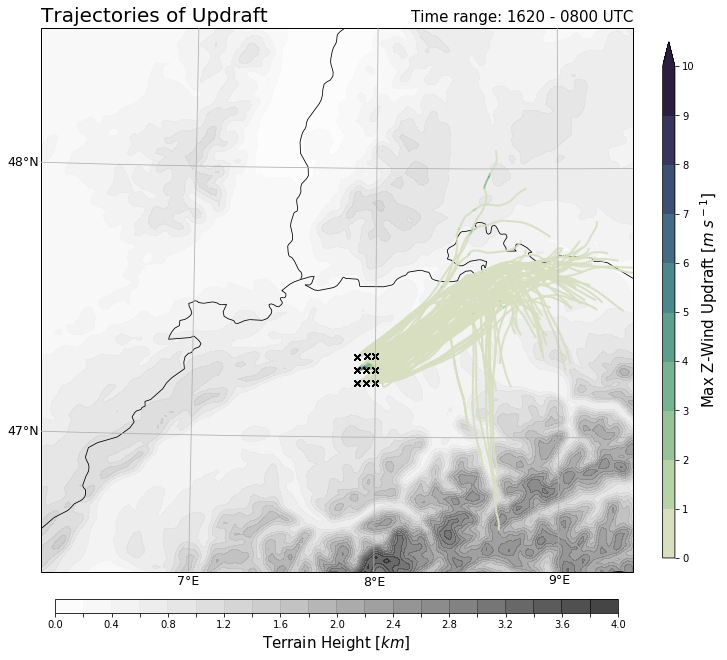

In [30]:
lagranto_plotting("updraft", "1620", "0800", trajs_bunch_level='all', 
                  subset=True, save=False)